In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-lightning

import torch
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

This work is Highly inspired by:
He et al [Link](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/lightgcn_deep_dive.ipynb).
and [Link](https://github.com/gusye1234/LightGCN-PyTorch)


In [ ]:
from torch_geometric.data import HeteroData, Data
import torch_geometric.transforms as T


In [ ]:
import os
import pickle
import random
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import train_test_split
from torch import Tensor, nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader, LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch_sparse import SparseTensor, matmul
from torchmetrics.retrieval import RetrievalMRR

In [ ]:
!wget http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip
!unzip dataset_tsmc2014.zip

--2025-01-11 14:35:58--  http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip
Resolving www-public.tem-tsp.eu (www-public.tem-tsp.eu)... 157.159.10.118
Connecting to www-public.tem-tsp.eu (www-public.tem-tsp.eu)|157.159.10.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25546284 (24M) [application/zip]
Saving to: ‘dataset_tsmc2014.zip’

dataset_tsmc2014.zi 100%[===================>]  24.36M  11.3MB/s    in 2.2s    

2025-01-11 14:36:01 (11.3 MB/s) - ‘dataset_tsmc2014.zip’ saved [25546284/25546284]

Archive:  dataset_tsmc2014.zip
   creating: dataset_tsmc2014/
  inflating: dataset_tsmc2014/dataset_TSMC2014_NYC.txt  
  inflating: dataset_tsmc2014/dataset_TSMC2014_readme.txt  
  inflating: dataset_tsmc2014/dataset_TSMC2014_TKY.txt  


The NYC foursquare dataset is not downloadable through this code:
!wget http://www-public.tem-tsp.eu/~zhang_da/pub/dataset_tsmc2014.zip
!unzip dataset_tsmc2014.zip
So I have downloaded manually and uploaded in the drive.

In [ ]:
columns = ['User ID',
           'Venue ID',
           'Venue category ID',
           'Venue category name',
           'Latitude',
           'Longitude',
           'Timezone',
           'UTC time']

df_path = 'dataset_tsmc2014/dataset_TSMC2014_NYC.txt'
df = pd.read_csv('dataset_tsmc2014/dataset_TSMC2014_NYC.txt', sep='\t', encoding='latin-1', names=columns)
print(df)

        User ID                  Venue ID         Venue category ID  \
0           470  49bbd6c0f964a520f4531fe3  4bf58dd8d48988d127951735   
1           979  4a43c0aef964a520c6a61fe3  4bf58dd8d48988d1df941735   
2            69  4c5cc7b485a1e21e00d35711  4bf58dd8d48988d103941735   
3           395  4bc7086715a7ef3bef9878da  4bf58dd8d48988d104941735   
4            87  4cf2c5321d18a143951b5cec  4bf58dd8d48988d1cb941735   
...         ...                       ...                       ...   
227423      688  3fd66200f964a52000e71ee3  4bf58dd8d48988d1e7931735   
227424      560  4bca32ff0687ef3be789dbcc  4bf58dd8d48988d16c941735   
227425      945  50a77716e4b0b5a9492f6f56  4bf58dd8d48988d103941735   
227426      671  4514efe0f964a520e7391fe3  4bf58dd8d48988d11d941735   
227427      942  4a1e0ca0f964a520bf7b1fe3  4bf58dd8d48988d116941735   

        Venue category name   Latitude  Longitude  Timezone  \
0       Arts & Crafts Store  40.719810 -74.002581      -240   
1                    

In [ ]:
# removing users who has less than 25 checkins so that it has higher proper probability and reassigning
user_checkin_counts = df['User ID'].value_counts()
valid_users = user_checkin_counts[user_checkin_counts >= 26].index
df_filtered_users = df[df['User ID'].isin(valid_users)]
df_sorted = df_filtered_users.sort_values(by=['User ID', 'UTC time']) # sorting with respective time
df_sorted
df_1 = df_sorted.copy()
venues = df_sorted['Venue ID'].unique()
categories = df_sorted['Venue category ID'].unique()
new_ids = list(range(len(venues)))
new_cat_ids = list(range(len(categories)))
mapping = dict(zip(venues, new_ids))
mapping_cat = dict(zip(categories, new_cat_ids))

df_1['Venue ID'] = df_1['Venue ID'].map(mapping)
df_1['Venue category ID'] = df_1['Venue category ID'].map(mapping_cat)

In [ ]:
# Time Preprocessing Localizes the 'UTC time' column of a DataFrame to the timezone specified in the 'Timezone' column
def apply_Timezone(data_df: pd.DataFrame):
    data_df['UTC time'] = pd.to_datetime(data_df['UTC time'], format='%a %b %d %H:%M:%S +0000 %Y')
    data_df['Timezone'] = pd.to_timedelta(data_df['Timezone'], unit='m')
    data_df['Localized time'] = data_df['UTC time'] + data_df['Timezone']
    data_df['Localized time'] = data_df['Localized time'].dt.strftime('%Y-%m-%d %H:%M')
    data_df.drop(columns=['Timezone', 'UTC time'], inplace=True)
    data_df = data_df.sort_values(by=['User ID', 'Localized time'])
    return data_df

In [ ]:
df_1 = apply_Timezone(df_1).reset_index(drop=True)

In [ ]:
# Display some statistics of the data
n_users = df_1['User ID'].nunique()
n_venues = df_1['Venue ID'].nunique()
n_categories = df_1['Venue category ID'].nunique()
n_names = df_1['Venue category name'].nunique()
print(f"Number of users: {n_users}  Number of venues: {n_venues}  Number of categories: {n_categories}  Number of category names: {n_names}")
n_different_times = df_1['Localized time'].nunique()
print(f"Number of different time-slots: {n_different_times}")
print(f"Number of check-ins: {df_1.shape[0]}")
df_1.head(50)

Number of users: 1083  Number of venues: 38333  Number of categories: 400  Number of category names: 251
Number of different time-slots: 129045
Number of check-ins: 227428


,User ID,Venue ID,Venue category ID,Venue category name,Latitude,Longitude,Localized time
0,1,33,4,Seafood Restaurant,40.781558,-73.975792,2012-04-04 19:31
1,1,16,14,American Restaurant,40.784018,-73.974524,2012-04-07 13:42
2,1,52,34,General Entertainment,40.739398,-73.993210,2012-04-08 14:20
3,1,53,8,American Restaurant,40.785677,-73.976498,2012-04-08 16:02
4,1,11,11,Breakfast Spot,40.719929,-74.008532,2012-04-09 12:20
5,1,70,3,Steakhouse,40.734276,-73.993525,2012-04-09 20:24
6,1,56,36,Bar,40.775986,-73.979528,2012-04-09 23:36
7,1,0,0,Mexican Restaurant,40.717888,-74.005668,2012-04-10 12:21
8,1,14,13,Coffee Shop,40.720087,-74.003961,2012-04-12 13:19
9,1,0,0,Mexican Restaurant,40.717888,-74.005668,2012-04-13 11:41


In [ ]:
# Drop duplicated rows
print(f"Number of rows before dropping duplicates: {df_1.shape[0]}")
df_1 = df_1.drop_duplicates()
print(f"Number of rows after dropping duplicates: {df_1.shape[0]}")

Number of rows before dropping duplicates: 227428
Number of rows after dropping duplicates: 226809


In [ ]:
user_info = df_1[['User ID', 'Venue ID', 'Localized time']].copy().reset_index(drop=True)
poi_info = df_1[['Venue ID', 'Latitude', 'Longitude', 'Venue category ID']].drop_duplicates(['Venue ID']).sort_values(by=['Venue ID']).reset_index(drop=True)

In [ ]:
user_info['Localized time'] = pd.to_datetime(user_info['Localized time'])   # Convert to datetime type

# Initialize a new column
user_info['mins since start'] = 0

# Find the oldest timestamp for each user
for user_id in user_info['User ID'].unique():
    oldest_timestamp = user_info[user_info['User ID']
                                 == user_id]['Localized time'].min()
    user_info.loc[user_info['User ID'] == user_id, 'mins since start'] = (
        (user_info[user_info['User ID'] == user_id]['Localized time'] - oldest_timestamp).dt.total_seconds() / 60).round().astype(int) + 1

user_info.drop(columns=['Localized time'], inplace=True)

user_info.head()

,User ID,Venue ID,mins since start
0,1,33,1
1,1,16,3972
2,1,52,5450
3,1,53,5552
4,1,11,6770


In [ ]:
# Create a HeteroData object for the bipartite graph
UserPOI_Graph = HeteroData()

undirected = T.ToUndirected()

user_ids = torch.tensor(user_info['User ID'].unique(), dtype=torch.long)
UserPOI_Graph['user'].num_nodes = len(user_ids)

# POI nodes (with features)
poi_ids = torch.tensor(poi_info['Venue ID'].unique(), dtype=torch.long)
UserPOI_Graph['poi'].num_nodes = len(poi_ids)

# Map Venue IDs to indices for feature lookup
poi_id_to_idx = {venue_id.item(): idx for idx, venue_id in enumerate(poi_ids)}

# Create POI feature tensor (Venue Category ID, Latitude, Longitude)
poi_features = []
for _, row in poi_info.iterrows():
    venue_id = row['Venue ID']
    features = torch.tensor(
        [row['Venue category ID'], row['Latitude'], row['Longitude']], dtype=torch.float)
    poi_features.append(features)
poi_features = torch.stack(poi_features)
UserPOI_Graph['poi'].x = poi_features

# Edge Indices

edge_index_user_to_poi = []
for _, row in user_info.iterrows():
    user_idx = torch.where(user_ids == row['User ID'])[0].item()
    poi_idx = poi_id_to_idx[row['Venue ID']]
    edge_index_user_to_poi.append([user_idx, poi_idx])

# Node Indexing
UserPOI_Graph['user'].node_idx = torch.arange(UserPOI_Graph['user'].num_nodes)
UserPOI_Graph['poi'].node_idx = torch.arange(UserPOI_Graph['poi'].num_nodes)

edge_index_user_to_poi = torch.tensor(
    edge_index_user_to_poi, dtype=torch.long).t().contiguous()
UserPOI_Graph['user', 'visits', 'poi'].edge_index = edge_index_user_to_poi

UserPOI_Graph = undirected(UserPOI_Graph)

print("Final edge indices pointing from users to POIs:")
print(edge_index_user_to_poi)

Final edge indices pointing from users to POIs:
tensor([[    0,     0,     0,  ...,  1082,  1082,  1082],
        [   33,    16,    52,  ...,  3857,  2603, 10053]])


In [ ]:
# Step needed for the HeteroData object to be validated: check if the graph is correctly constructed
print("Validating the HeteroData: ", UserPOI_Graph.validate(raise_on_error=True))
print("\nGraph structure: \n", UserPOI_Graph)

Validating the HeteroData:  True

Graph structure: 
 HeteroData(
  user={
    num_nodes=1083,
    node_idx=[1083],
  },
  poi={
    num_nodes=38333,
    x=[38333, 3],
    node_idx=[38333],
  },
  (user, visits, poi)={ edge_index=[2, 226809] },
  (poi, rev_visits, user)={ edge_index=[2, 226809] }
)


In [ ]:
with open("UserPOI_Graph.pickle", "wb") as f:
    pickle.dump(UserPOI_Graph, f)
print("File created.")


File created.


In [ ]:
# Create a NetworkX bipartite graph
B = nx.Graph()
first_five_users = range(5)

edge_index_user_to_poi = UserPOI_Graph['user', 'visits', 'poi'].edge_index
user_ids = UserPOI_Graph['user'].node_idx

# Get all POIs visited by the first 5 users
visited_pois = set()
for i in first_five_users:
    user_visits = edge_index_user_to_poi[1][edge_index_user_to_poi[0] == i]
    visited_pois.update(user_visits.tolist())

# Count the frequency of each POI visit
poi_visit_counts = {poi: 0 for poi in visited_pois}
for i in first_five_users:
    user_visits = edge_index_user_to_poi[1][edge_index_user_to_poi[0] == i]
    for poi in user_visits:
        poi_visit_counts[poi.item()] += 1

# Select the top 8 most commonly visited POIs
common_pois = sorted(
    poi_visit_counts, key=poi_visit_counts.get, reverse=True)[:8]
poi_indices = [len(user_ids) + poi for poi in common_pois]

# Add user and POI nodes to the graph
B.add_nodes_from(first_five_users, bipartite=0, label='user')
B.add_nodes_from(poi_indices, bipartite=1, label='poi')

# Add edges to the graph
for i in range(edge_index_user_to_poi.size(1)):
    user, poi = edge_index_user_to_poi[:, i].tolist()
    if user < 5 and poi in common_pois:  # Only add edges for the first 5 users and common POIs
        B.add_edge(user, len(user_ids) + poi)

# Draw the bipartite graph
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(
    first_five_users))  # Put user nodes on the left
pos.update((n, (2, i)) for i, n in enumerate(
    poi_indices))       # Put poi nodes on the right

nx.draw(B, pos, with_labels=True, node_color=['skyblue' if n < 5 else 'red' for n in B.nodes])



In [ ]:
# Create a RandomLinkSplit transform for Splitting Data
transform = RandomLinkSplit(
    num_val=0.1,    # 10% of the data for validation
    num_test=0.1,   # 10% of the data for testing
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2,
    add_negative_train_samples=False,
    edge_types=('user', 'visits', 'poi'),
    is_undirected=True  # Ensure the graph is undirected
)

train_data, val_data, test_data = transform(UserPOI_Graph)

# Create a LinkNeighborLoader Data Loaders for training, validation, and testing
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[30, 20],
    neg_sampling_ratio=10,
    edge_label_index=(('user', 'visits', 'poi'),
                      train_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=train_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=True,
)

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(('user', 'visits', 'poi'),
                      test_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=test_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=False,
)

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(('user', 'visits', 'poi'),
                      val_data['user', 'visits', 'poi'].edge_label_index),
    edge_label=val_data['user', 'visits', 'poi'].edge_label,
    batch_size=128,
    shuffle=False,
)

# Sample data from the loaders to check
sampled_train_data = next(iter(train_loader))
sampled_test_data = next(iter(test_loader))
sampled_val_data = next(iter(val_loader))

print("Sampled data from the train loader:", sampled_train_data)
print("Sampled data from the test loader:", sampled_test_data)
print("Sampled data from the val loader:", sampled_val_data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Sampled data from the train loader: HeteroData(
  user={
    num_nodes=1083,
    node_idx=[1083],
    n_id=[1083],
  },
  poi={
    num_nodes=14086,
    x=[14086, 3],
    node_idx=[14086],
    n_id=[14086],
  },
  (user, visits, poi)={
    edge_index=[2, 65174],
    edge_label=[1408],
    edge_label_index=[2, 1408],
    e_id=[65174],
    input_id=[128],
  },
  (poi, rev_visits, user)={
    edge_index=[2, 28430],
    e_id=[28430],
  }
)
Sampled data from the test loader: HeteroData(
  user={
    num_nodes=1010,
    node_idx=[1010],
    n_id=[1010],
  },
  poi={
    num_nodes=3407,
    x=[3407, 3],
    node_idx=[3407],
    n_id=[3407],
  },
  (user, visits, poi)={
    edge_index=[2, 12133],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[12133],
    input_id=[128],
  },
  (poi, rev_visits, user)={
    edge_index=[2, 4930],
    e_id=[4930],
  }
)
Sampled data from the val loader: HeteroData(
  user={
    num_nodes=1005,
    node_idx=[1005],
    n_id=[1005],
  },
  poi={
   

In [ ]:
edge_index = UserPOI_Graph['user', 'visits', 'poi'].edge_index  # Edge indices

num_interactions = edge_index.shape[1]              # Number of interactions, namely poi visits
all_indices = [i for i in range(num_interactions)]  # All indices, namely all edges

# HYPERPARAMETERS
NUM_USERS = UserPOI_Graph['user'].num_nodes # Number of user nodes
NUM_POIS = UserPOI_Graph['poi'].num_nodes   # Number of POI nodes

EMBEDDING_DIM = 128                     # Embedding dimension
NUM_LAYERS = 3                          # Number of layers
LAMBDA_VAL = 1e-6                       # Regularization parameter for the loss function

In [ ]:
train_indices, test_indices = train_test_split(all_indices, test_size=0.3, random_state=2057231)   # Split the indices into train set and a temporary test set,
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=2057231)  # Split the test indices into validation and test sets

train_edge_index = edge_index[:, train_indices]     # Train edge indices, filtered by train indices mask
val_edge_index = edge_index[:, val_indices]        # Validation edge indices, filtered by validation indices mask
test_edge_index = edge_index[:, test_indices]   # Test edge indices, filtered by test indices mask

In [ ]:
train_loader = DataLoader(train_edge_index.T, batch_size=1028, shuffle=True)    # Train data loader
val_loader = DataLoader(val_edge_index.T, batch_size=1028, shuffle=False)       # Validation data loader
test_loader = DataLoader(test_edge_index.T, batch_size=1028, shuffle=False)     # Test data loader

In [ ]:
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1]+NUM_USERS, sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))       # Train sparse edge index
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1]+NUM_USERS, sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))        # Test sparse edge index
validation_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1]+NUM_USERS, sparse_sizes=(NUM_USERS + NUM_POIS, NUM_USERS + NUM_POIS))  # Validation sparse edge index

In [ ]:
print(train_sparse_edge_index)
print(test_sparse_edge_index)
print(validation_sparse_edge_index)

SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1083,  1083,  1084,  ..., 39412, 39414, 39415]),
             size=(39416, 39416), nnz=158766, density=0.01%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1090,  1093,  1093,  ..., 35585, 37987, 39410]),
             size=(39416, 39416), nnz=34022, density=0.00%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 1082, 1082, 1082]),
             col=tensor([ 1083,  1093,  1093,  ..., 39407, 39410, 39413]),
             size=(39416, 39416), nnz=34021, density=0.00%)


In [ ]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=EMBEDDING_DIM, K=NUM_LAYERS, add_self_loops=False):

        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim)  # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim)  # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):

        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)
        all_embs = torch.cat([self.users_emb.weight, self.items_emb.weight]).cuda()
        embs = [all_embs]
        emb_k = all_embs

        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            emb_k = emb_k.cuda()
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)
        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.cpu()
        x = x.cpu()
        return matmul(adj_t, x)

# Define the LightGCNRecSys model because lightning does not support MessagePassing
class LightGCNRecSys(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=EMBEDDING_DIM, K=NUM_LAYERS, add_self_loops=False):
        super().__init__()
        self.model = LightGCN(num_users, num_items,
                              embedding_dim, K, add_self_loops)

    def forward(self, edge_index: SparseTensor):
        users_emb_final, users_emb, items_emb_final, items_emb = self.model(
            edge_index)
        return users_emb_final, users_emb, items_emb_final, items_emb


In [ ]:
def positive_user_interactions(edge_index):
    user_pos_items = {}                     # Dictionary to store user positive items
    for i in range(edge_index.shape[1]):    # Iterate over the edge index
        user = edge_index[0][i].item()      # Get the user index
        item = edge_index[1][i].item()      # Get the item index
        if user not in user_pos_items:      # If the user is not already in the dictionary, an empty list is created for that user
            user_pos_items[user] = []
        user_pos_items[user].append(item)   # Append the item to the user's positive items

    return user_pos_items

In [ ]:
class LightGCNModule(pl.LightningModule):
    def __init__(self, num_users, num_items, embedding_dim, num_layers, add_self_loops=False):
        super().__init__()
        self.network = LightGCNRecSys(
            num_users, num_items, embedding_dim, num_layers, add_self_loops)

    def forward(self, sparse_tensor: SparseTensor):
        users_emb_final, users_emb, items_emb_final, items_emb = self.network(
            sparse_tensor)
        return users_emb_final, users_emb, items_emb_final, items_emb

    def bpr_loss(self, users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
        reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                                 pos_items_emb_0.norm(2).pow(2) +
                                 neg_items_emb_0.norm(2).pow(2))  # L2 loss

        pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
        pos_scores = torch.sum(pos_scores, dim=-1)
        neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
        neg_scores = torch.sum(neg_scores, dim=-1)

        loss = - torch.mean(torch.nn.functional.softplus(
                pos_scores - neg_scores)) + reg_loss

        return loss

    def training_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(
            train_sparse_edge_index)    # Forward pass
        batch = batch.T                 # Transpose the batch for pytorch geometric structure requirements
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])    # Negative sampling: sample negative edges

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]         # Get user embeddings for the user indices
        users_emb_0Loss = users_emb_0[user_indices]                 # Get user weight embeddings for the user indices
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices] # Get item embeddings for the positive item indices
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]         # Get item weight embeddings for the positive item indices
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices] # Get item embeddings for the negative item indices
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]         # Get item weight embeddings for the negative item indices

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculate the loss
        self.log("train_loss", float(f"{loss:.5f}"), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(
            validation_sparse_edge_index)   # Forward pass
        batch = batch.T                     # Transpose the batch for pytorch geometric structure requirements
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])    # Negative sampling: sample negative edges

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]
        users_emb_0Loss = users_emb_0[user_indices]
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices]
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices]
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculate the loss
        acc, mrr = self.get_metrics(
            val_edge_index, train_edge_index, validation_sparse_edge_index, k=[1, 3, 5])
        self.log("val_loss", float(f"{loss:.5f}"), prog_bar=True)
        for k, v in acc.items():
            self.log(f"val_acc@{k}", float(f"{v:.5f}"))
        self.log("val_mrr", float(f"{mrr:.5f}"))
        return loss

    def test_step(self, batch, batch_idx):
        users_emb_final, users_emb_0, items_emb_final, items_emb_0 = self.forward(test_sparse_edge_index)   # Forward pass
        batch = batch.T
        batch_neg_edges = negative_sampling(
            edge_index, num_nodes=[NUM_USERS, NUM_POIS], num_neg_samples=batch.shape[1])

        user_indices = batch[0]
        pos_item_indices = batch[1]
        neg_item_indices = batch_neg_edges[1]

        users_emb_finalLoss = users_emb_final[user_indices]
        users_emb_0Loss = users_emb_0[user_indices]
        pos_items_emb_finalLoss = items_emb_final[pos_item_indices]
        pos_items_emb_0Loss = items_emb_0[pos_item_indices]
        neg_items_emb_finalLoss = items_emb_final[neg_item_indices]
        neg_items_emb_0Loss = items_emb_0[neg_item_indices]

        loss = self.bpr_loss(users_emb_finalLoss, users_emb_0Loss, pos_items_emb_finalLoss,
                             pos_items_emb_0Loss, neg_items_emb_finalLoss, neg_items_emb_0Loss, LAMBDA_VAL) # Calculating the loss
        acc, mrr = self.get_metrics(
            test_edge_index, train_edge_index, test_sparse_edge_index, k=[1, 3, 5])
        self.log("test_loss", float(f"{loss:.5f}"), prog_bar=True)
        for k, v in acc.items():
            self.log(f"test_acc@{k}", float(f"{v:.5f}"))
        self.log("test_mrr", float(f"{mrr:.5f}"))
        return loss

    def get_metrics(self, edge_index, exclude_edge_index, sparse_edge_index, k=[1, 3, 5]):
        _, user_embedding, _, item_embedding = self.forward(sparse_edge_index)  # Get embeddings

        rating = torch.matmul(user_embedding, item_embedding.T) # Calculate ratings

        exclude_users = exclude_edge_index[0].tolist()
        exclude_items = exclude_edge_index[1].tolist()

        rating[exclude_users, exclude_items] = -(1 << 10)

        users = edge_index[0].unique()
        set_user_pos_items = positive_user_interactions(
            edge_index)  # Positive items in current set

        acc_at_k = {}
        # Get top-k for all k values at once
        _, top_K_items = rating.topk(k=max(k), dim=1)

        ground_truth_items = pad_sequence(
            [torch.tensor(set_user_pos_items[user.item()], device=rating.device) for user in users], batch_first=True, padding_value=-1) # Padding: not all users have the same number of positive items (required for casting to tensor)
        r = torch.zeros_like(top_K_items, dtype=torch.bool)

        for i, user_ground_truth in enumerate(ground_truth_items):
            r[i] = torch.isin(top_K_items[i], user_ground_truth)    # Check if the top-k items are in the ground truth

        acc_at_k = {k_value: r[:, :k_value].sum(1).float().mean().item() for k_value in k}  # Calculate accuracy at k

        # Calculate MRR
        top_poi = top_K_items[:, 0] # Top item
        ranks = (ground_truth_items == top_poi[:, None]).nonzero(as_tuple=True)[1] + 1   # Calculate ranks
        mrr = ((1.0 / ranks[ranks > 0]).sum()) / sum(len(value)
          for value in set_user_pos_items.values())  # Calculate MRR
        return acc_at_k, mrr

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)   # Adam optimizer
        return optimizer

In [ ]:

early_stop_callback = EarlyStopping( monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")  # Early stopping callback

LOGGER = CSVLogger("logs", name="LightGCN-ReccSys") # Logger

trainer = pl.Trainer(default_root_dir="/Link_Pred",
                     accelerator="gpu" if torch.cuda.is_available() else "cpu",
                     devices=1,
                     max_epochs=30,
                     precision=16,
                     logger=LOGGER,
                     log_every_n_steps=5,
                     callbacks=early_stop_callback)
model = LightGCNModule(NUM_USERS, NUM_POIS, EMBEDDING_DIM, NUM_LAYERS, False)   # Instantiate the model
print("Training a new model from scratch")

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training a new model from scratch


In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | network | LightGCNRecSys | 5.0 M  | train
---------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.181    Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Test the model
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc@1         │   0.0055399988777935505   │
│        test_acc@3         │   0.020309997722506523    │
│        test_acc@5         │    0.03415998816490173    │
│         test_loss         │    -30.19415855407715     │
│         test_mrr          │   4.000000626547262e-05   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -30.19415855407715,
  'test_acc@1': 0.0055399988777935505,
  'test_acc@3': 0.020309997722506523,
  'test_acc@5': 0.03415998816490173,
  'test_mrr': 4.000000626547262e-05}]

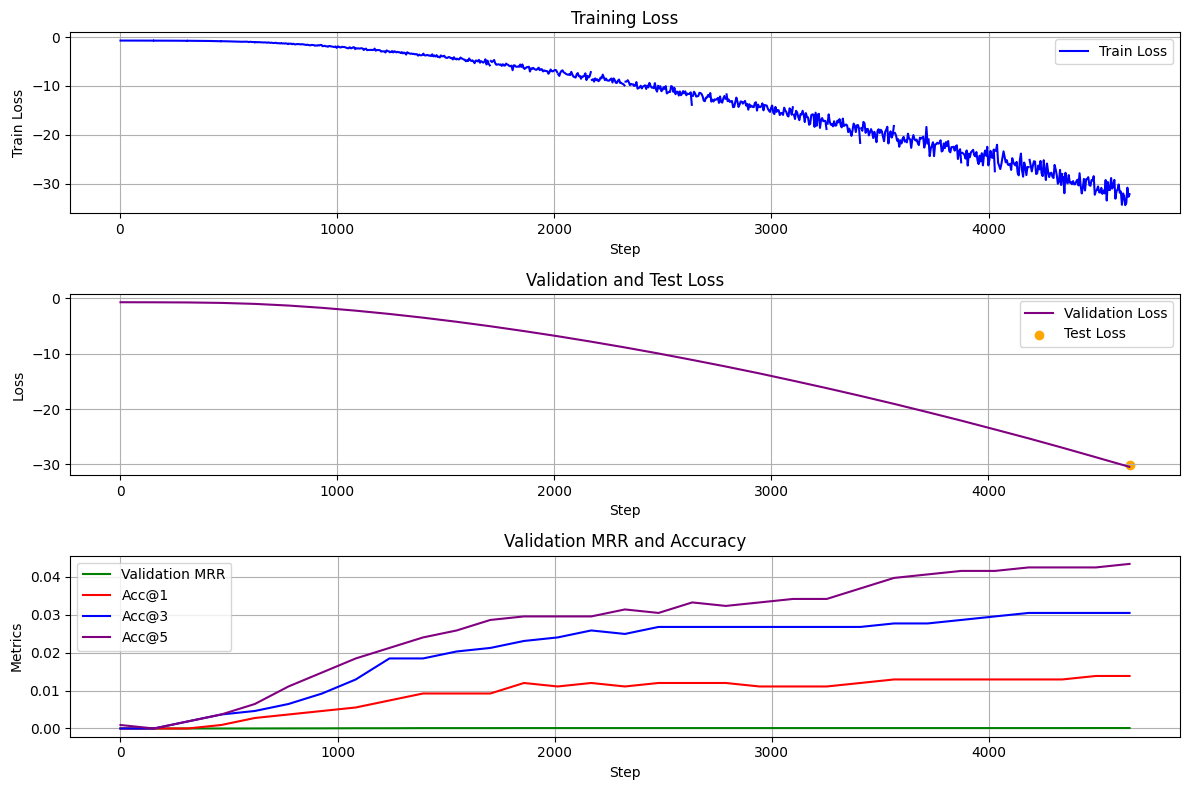

In [ ]:
# Read the CSV file
file_path = "logs/LightGCN-ReccSys/version_0/metrics.csv"  # Update if needed
df = pd.read_csv(file_path)

# Filter out the rows where the validation and test metrics are present
val_metrics = df.dropna(subset=['val_loss'])
test_metrics = df.dropna(subset=['test_loss'])

# Plotting train loss and other metrics
plt.figure(figsize=(12, 8))

# Plot train loss
plt.subplot(3, 1, 1)
plt.plot(df['step'], df['train_loss'], label='Train Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss and test loss using scatter plots
plt.subplot(3, 1, 2)
if not val_metrics.empty:
    plt.plot(val_metrics['step'], val_metrics['val_loss'], label='Validation Loss', color='blue')
if not test_metrics.empty:
    plt.scatter(test_metrics['step'], test_metrics['test_loss'], label='Test Loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation and Test Loss')
plt.legend()
plt.grid(True)

# Plot validation MRR and validation accuracy
plt.subplot(3, 1, 3)
plt.plot(val_metrics['step'], val_metrics['val_mrr'], label='Validation MRR', color='red')
plt.plot(val_metrics['step'], val_metrics['val_acc@1'], label='Acc@1', color='green')
plt.plot(val_metrics['step'], val_metrics['val_acc@3'], label='Acc@3', color='black')
plt.plot(val_metrics['step'], val_metrics['val_acc@5'], label='Acc@5', color='blue')
plt.xlabel('Step')
plt.ylabel('Metrics')
plt.title('Validation MRR and Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def recommend(user_ID, num_recommendations):
    user_pos_items = positive_user_interactions(edge_index) # Positive items in the edge index
    user_ID = user_ID - 1 # User ID starts from 1, tensors and other mappings start from 0

    _, user_embedding_w,  _, item_embedding_w = model.forward(test_sparse_edge_index)  # Get embeddings
    user_embedding_w = user_embedding_w[user_ID]
    rating = item_embedding_w @ user_embedding_w # Calculate ratings

    exclude_items = user_pos_items[user_ID] # Exclude positive items
    rating[exclude_items] = -(1 << 10)

    _, indices = torch.topk(rating, k=num_recommendations)
    return indices.tolist()

# user = random.randint(0, NUM_USERS)
user = 150
recs = recommend(user, 5)

filtered_df = df_1[df_1['Venue ID'].isin(recs)].drop_duplicates(subset=['Venue ID'])
result = filtered_df[['Venue ID', 'Venue category name']]
venue_dict = dict(zip(result['Venue ID'], result['Venue category name']))
formatted_recs = [f"{venue_id} ({venue_dict.get(venue_id, 'Unknown')})" for venue_id in recs]

# Print the recommendations with category names
print(f"Recommendations for user {user}:")
for rec in formatted_recs:
    print(rec)

Recommendations for user 150:
7177 (Office)
18684 (Mall)
27639 (Other Great Outdoors)
434 (Train Station)
18952 (Office)


In [ ]:
df_path = 'dataset_tsmc2014/dataset_TSMC2014_NYC.txt'
df = pd.read_csv('dataset_tsmc2014/dataset_TSMC2014_NYC.txt', sep='\t', encoding='latin-1', names=columns)
!pip install python-geohash
!pip install geoh

  Preparing metadata (setup.py) ... done
  Created wheel for python-geohash: filename=python_geohash-0.8.5-cp310-cp310-linux_x86_64.whl size=41543 sha256=ed87dc7677503d260de226664b8b530fa1d6c6bfa4b0098162fe6034ca0d0c9f
  Stored in directory: /root/.cache/pip/wheels/19/e8/74/3f800ffdbb57c27a3fee3a695c7009769356448837c1f4f899
Successfully built python-geohash
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geoh: filename=geoh-0.3-py3-none-any.whl size=4326 sha256=ffc4e509b42c11309857c069aadc92873c61380e6baa42beb6815534abad196b
  Stored in directory: /root/.cache/pip/wheels/cf/e1/2a/dac4ada7296bb3c3e96ea8b172a19c0b5f74a9304c145d0607
Successfully built geoh


In [ ]:
import geohash
import pandas as pd


def calculate_geohash(df, precision):
    return df.apply(lambda row: geohash.encode(row['Latitude'], row['Longitude'], precision=precision), axis=1)

df['Geohash_P2'] = calculate_geohash(df, precision=2)
df['Geohash_P3'] = calculate_geohash(df, precision=3)
df['Geohash_P4'] = calculate_geohash(df, precision=4)
df['Geohash_P5'] = calculate_geohash(df, precision=5)
df['Geohash_P6'] = calculate_geohash(df, precision=6)

# GeoHash Column
print(df[['Latitude', 'Longitude', 'Geohash_P2', 'Geohash_P3', 'Geohash_P4', 'Geohash_P5', 'Geohash_P6']].head())


    Latitude  Longitude Geohash_P2 Geohash_P3 Geohash_P4 Geohash_P5 Geohash_P6
0  40.719810 -74.002581         dr        dr5       dr5r      dr5rs     dr5rsh
1  40.606800 -74.044170         dr        dr5       dr5r      dr5r5     dr5r50
2  40.716162 -73.883070         dr        dr5       dr5r      dr5rw     dr5rws
3  40.745164 -73.982519         dr        dr5       dr5r      dr5ru     dr5ru3
4  40.740104 -73.989658         dr        dr5       dr5r      dr5ru     dr5ru2


In [ ]:
import pandas as pd
from collections import defaultdict

def create_user_region_matrix(df, geohash_column):
    user_region_dict = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        user_id = row['User ID']
        region = row[geohash_column]
        user_region_dict[user_id][region] += 1

    user_region_df = pd.DataFrame(user_region_dict).fillna(0).astype(int).T

    return user_region_df

user_region_p2 = create_user_region_matrix(df, 'Geohash_P2')
user_region_p3 = create_user_region_matrix(df, 'Geohash_P3')
user_region_p4 = create_user_region_matrix(df, 'Geohash_P4')
user_region_p5 = create_user_region_matrix(df, 'Geohash_P5')
user_region_p6 = create_user_region_matrix(df, 'Geohash_P6')


print("User-Region Matrix (Geohash_P2):")
print(user_region_p2)


User-Region Matrix (Geohash_P2):
       dr
470   196
979   179
69    404
395   106
87    135
...   ...
808   141
600   123
911   239
1081  100
849   152

[1083 rows x 1 columns]


In [ ]:
#labelencodng
from sklearn.preprocessing import LabelEncoder
le_p2 = LabelEncoder()
le_p3 = LabelEncoder()
le_p4 = LabelEncoder()
le_p5 = LabelEncoder()
le_p6 = LabelEncoder()
#fitting
df['Geohash_P2'] = le_p2.fit_transform(df['Geohash_P2'])
df['Geohash_P3'] = le_p3.fit_transform(df['Geohash_P3'])
df['Geohash_P4'] = le_p4.fit_transform(df['Geohash_P4'])
df['Geohash_P5'] = le_p5.fit_transform(df['Geohash_P5'])
df['Geohash_P6'] = le_p6.fit_transform(df['Geohash_P6'])
print(user_region_p4)

      dr5r  dr5q  dr72  dr78  dr5x  dr73  dr5p  dr70  dr5w  dr5n
470    164     2    28     2     0     0     0     0     0     0
979     94    83     2     0     0     0     0     0     0     0
69     378     0     3     0    21     2     0     0     0     0
395    103     0     1     2     0     0     0     0     0     0
87     133     0     2     0     0     0     0     0     0     0
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
808     98     0    42     0     1     0     0     0     0     0
600    112     0     9     0     0     0     2     0     0     0
911    239     0     0     0     0     0     0     0     0     0
1081    34     0     0     1    65     0     0     0     0     0
849    138     0    14     0     0     0     0     0     0     0

[1083 rows x 10 columns]


In [ ]:

df['UTC time'] = pd.to_datetime(df['UTC time'], format='%a %b %d %H:%M:%S %z %Y')

missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

df = df.dropna()

df['Year'] = df['UTC time'].dt.year
df['Month'] = df['UTC time'].dt.month
df['Day'] = df['UTC time'].dt.day
df['Hour'] = df['UTC time'].dt.hour
df['Day of Week'] = df['UTC time'].dt.dayofweek

venue_category_encoder = LabelEncoder()
df['Venue category name'] = venue_category_encoder.fit_transform(df['Venue category name'])

user_encoder = LabelEncoder()
df['User ID'] = user_encoder.fit_transform(df['User ID'])

venue_encoder = LabelEncoder()
df['Venue ID'] = venue_encoder.fit_transform(df['Venue ID'])

print(df.head())

unique_pois = df['Venue ID'].unique()
unique_users = df['User ID'].unique()

poi_to_idx = {poi: idx for idx, poi in enumerate(unique_pois)}
user_to_idx = {user: idx for idx, user in enumerate(unique_users)}

user_sequences = {}
for user in unique_users:
    user_data = df[df['User ID'] == user]
    visit_sequence = list(zip(
        user_data['Venue ID'].map(poi_to_idx),
        user_data['Latitude'].astype(str) + ',' + user_data['Longitude'].astype(str),
        pd.to_datetime(user_data['UTC time']).astype(int) // 10**9  # unixtime
    ))
    user_sequences[user] = visit_sequence
print(f"Number of unique POIs: {len(unique_pois)}")
print(f"Number of unique users: {len(unique_users)}")
print(f"Example visit sequence for a user: {user_sequences[unique_users[0]][:5]}")

Missing Data:
 User ID                0
Venue ID               0
Venue category ID      0
Venue category name    0
Latitude               0
Longitude              0
Timezone               0
UTC time               0
Geohash_P2             0
Geohash_P3             0
Geohash_P4             0
Geohash_P5             0
Geohash_P6             0
dtype: int64
   User ID  Venue ID         Venue category ID  Venue category name  \
0      469      2388  4bf58dd8d48988d127951735                   12   
1      978      3921  4bf58dd8d48988d1df941735                   34   
2       68     20328  4bf58dd8d48988d103941735                  121   
3      394     15114  4bf58dd8d48988d104941735                  141   
4       86     23550  4bf58dd8d48988d1cb941735                   95   

    Latitude  Longitude  Timezone                  UTC time  Geohash_P2  \
0  40.719810 -74.002581      -240 2012-04-03 18:00:09+00:00           0   
1  40.606800 -74.044170      -240 2012-04-03 18:00:25+00:00           

In [ ]:
import networkx as nx
import pandas as pd
from itertools import combinations
from tqdm.notebook import tqdm


sample_fraction = 0.1  #crearing graphg by batch processs
poi_geohash_p4 = df[['Venue ID', 'Geohash_P4']].drop_duplicates().sample(frac=sample_fraction, random_state=42)

G_s = nx.Graph()

poi_ids = poi_geohash_p4['Venue ID'].unique()
G_s.add_nodes_from(poi_ids)

batch_size = 1000  # batchSize

for geohash, group in tqdm(poi_geohash_p4.groupby('Geohash_P4')):
    pois_in_same_geohash = group['Venue ID'].tolist()


    for i in range(0, len(pois_in_same_geohash), batch_size):
        batch_pois = pois_in_same_geohash[i:i + batch_size]
        for poi1, poi2 in combinations(batch_pois, 2):
            G_s.add_edge(poi1, poi2)

print(f"Number of nodes (POIs): {G_s.number_of_nodes()}")
print(f"Number of edges: {G_s.number_of_edges()}")
from torch_geometric.utils import from_networkx
data = from_networkx(G_s)

print("Graph data object:", data)


  0%|          | 0/9 [00:00<?, ?it/s]

Number of nodes (POIs): 3835
Number of edges: 1506469
Graph data object: Data(edge_index=[2, 3012938], num_nodes=3835)


In [ ]:
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import combinations
from tqdm.notebook import tqdm
from functools import lru_cache

def get_time_slot(hour):
    return hour // 3

df['Time Slot'] = df['Hour'].apply(get_time_slot)

sample_fraction = 0.1
df_sampled = df.sample(frac=sample_fraction, random_state=42)

# timeslot
poi_time_slots = defaultdict(set)
for _, row in df_sampled.iterrows():
    poi_id = row['Venue ID']
    time_slot = row['Time Slot']
    poi_time_slots[poi_id].add(time_slot)

#jaccard
@lru_cache(maxsize=10000)
def jaccard_similarity_cached(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union
G_t = nx.Graph()
G_t.add_nodes_from(poi_time_slots.keys())

batch_size = 1000  # Adjust batch size
keys_list = list(poi_time_slots.keys())

# Process in batches
for i in tqdm(range(0, len(keys_list), batch_size)):
    batch_pois = keys_list[i:i + batch_size]
    for poi1, poi2 in combinations(batch_pois, 2):
        similarity = jaccard_similarity_cached(frozenset(poi_time_slots[poi1]), frozenset(poi_time_slots[poi2]))
        if similarity > 0.9:
            G_t.add_edge(poi1, poi2)

print(f"Number of nodes (POIs): {G_t.number_of_nodes()}")
print(f"Number of edges: {G_t.number_of_edges()}")

# data
from torch_geometric.utils import from_networkx
temporal_data = from_networkx(G_t)

print("Temporal graph data object:", temporal_data)


  0%|          | 0/12 [00:00<?, ?it/s]

Number of nodes (POIs): 11276
Number of edges: 474944
Temporal graph data object: Data(edge_index=[2, 949888], num_nodes=11276)
